In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")

# change this line to the where directory in which the GitHub repository is located: datasets will be installed into 
# the directory one level above this
os.chdir("/lustre_scratch/orlando-code/coralshift/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import matplotlib.pyplot as plt

from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingRegressor,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics as sklmetrics

from coralshift.utils import directories, file_ops
from coralshift.plotting import spatial_plots, model_results
from coralshift.processing import spatial_data
from coralshift.machine_learning import baselines

# Literature Methods Comparison
### Visualise example data and run simple models

Toy data – `GBR_A_Couce_comparison.nc` – is available for download from the Zenodo platform: https://doi.org/10.5281/zenodo.8110926.

Place it in the `coralshift` directory (repository cloned from GitHub).

In [ ]:
# load dataset
couce_xa = file_ops.open_xa_file(directories.get_coralshift_dir() / "GBR_A_Couce_comparison.nc")
# visualise metadata
couce_xa

<xarray.Dataset>
Dimensions:              (latitude: 190, longitude: 136)
Coordinates:
  * longitude            (longitude) float64 142.0 142.0 142.1 ... 147.0 147.0
  * latitude             (latitude) float64 -17.0 -16.96 -16.93 ... -10.04 -10.0
    band                 int64 ...
    spatial_ref          int64 0
Data variables: (12/18)
    thetao_y_mean        (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    thetao_annual_range  (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    thetao_m_min         (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    thetao_m_max         (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    thetao_m_std         (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    thetao_w_min         (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...                   ...
    current_m_max        (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    net_solar_y_mean     (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    net_solar_m_min      (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    net_solar_m_max      (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    gt                   (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    bathymetry           (latitude, longitude) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
Attributes:
    region:   A

## Visualise data

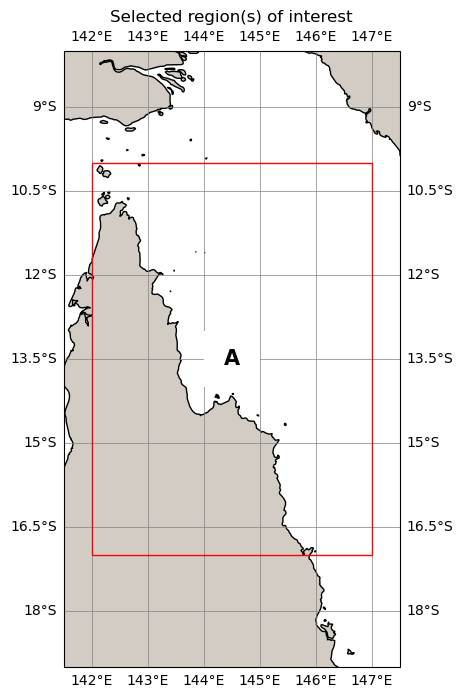

In [ ]:
# visualise region in context
spatial_plots.plot_reef_areas(region = ["A"])

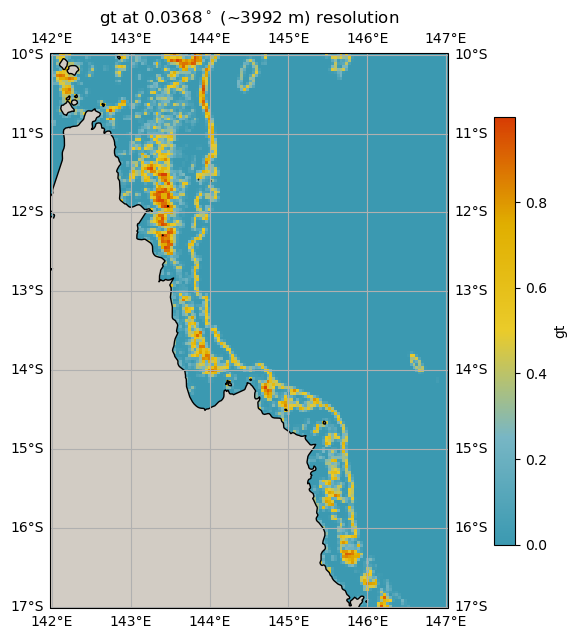

In [ ]:
# visualise ground truth
spatial_plots.plot_spatial(couce_xa["gt"], figsize=[6,10]);

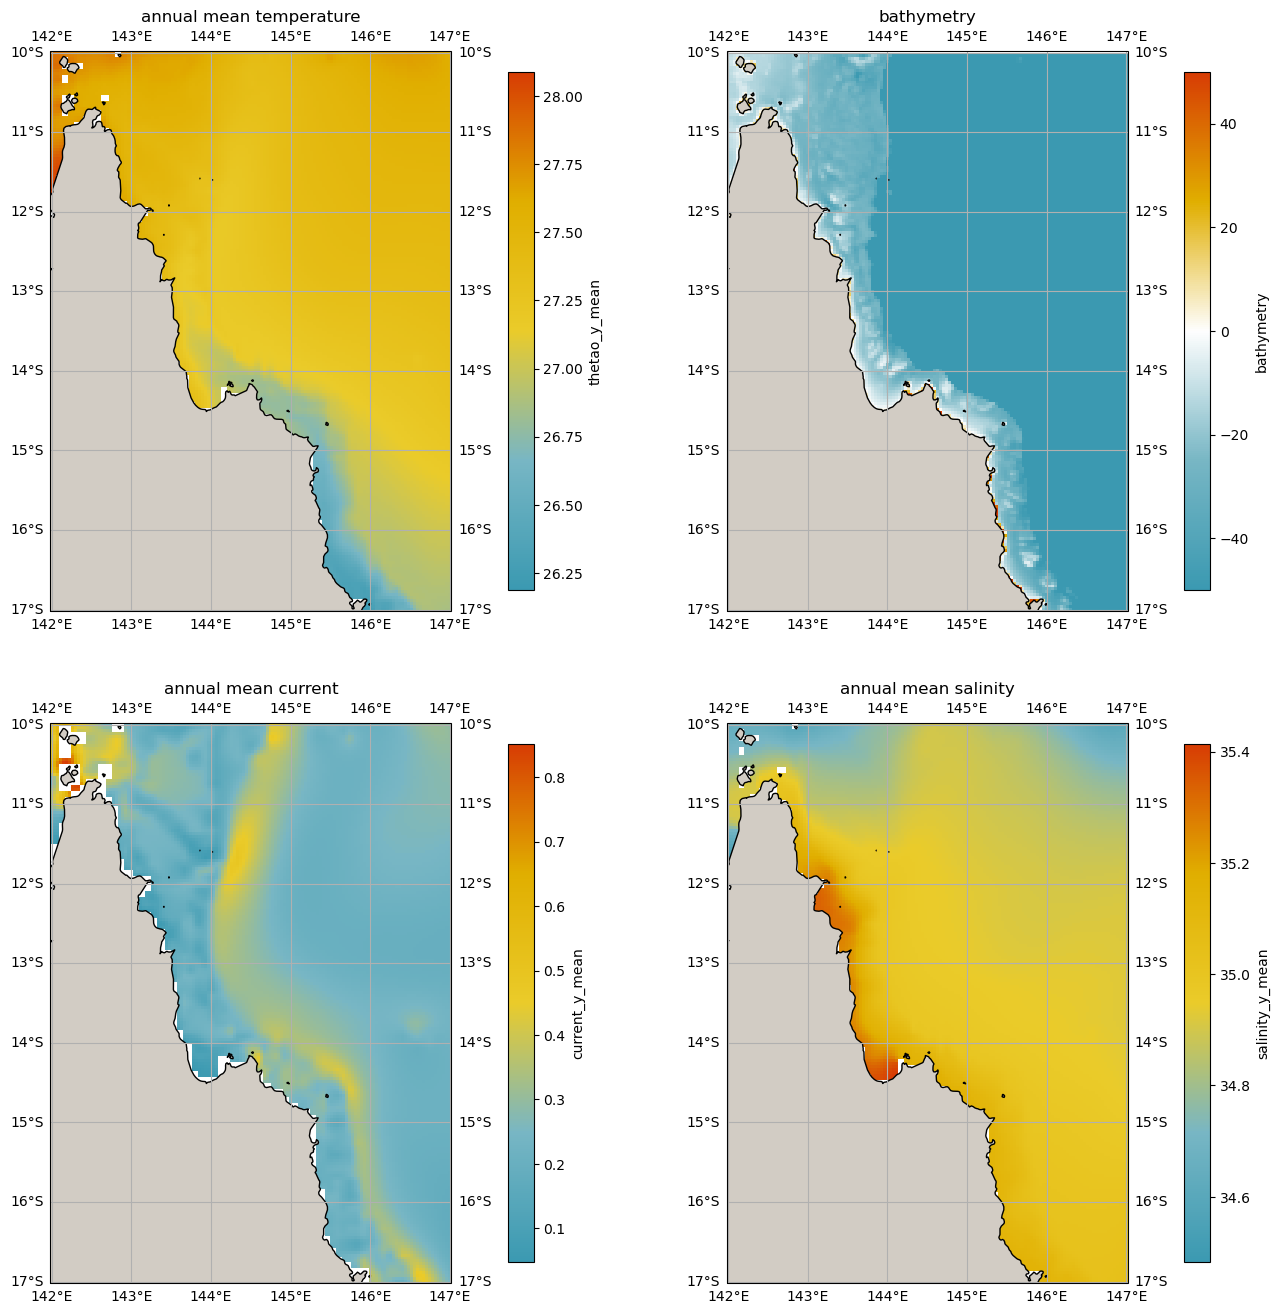

In [ ]:
# visualise example variables
import cartopy.crs as ccrs
fig, axes = plt.subplots(2, 2, figsize=(16, 16), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flat


# annual mean temperature
_ = spatial_plots.plot_spatial(couce_xa["thetao_y_mean"], fax=(fig, axes[0]), title="annual mean temperature")
# bathymetry
_ = spatial_plots.plot_spatial(couce_xa["bathymetry"], fax=(fig, axes[1]), title="bathymetry", cmap_type="div", val_lims=[-50,50])
# annual mean current
_ = spatial_plots.plot_spatial(couce_xa["current_y_mean"], fax=(fig, axes[2]), title="annual mean current")
# salinity_y_mean
_ = spatial_plots.plot_spatial(couce_xa["salinity_y_mean"], fax=(fig, axes[3]), title="annual mean salinity")

Buffering variables by 7 pixel(s): 100%|██████████| 18/18 [00:00<00:00, 213.31it/s]


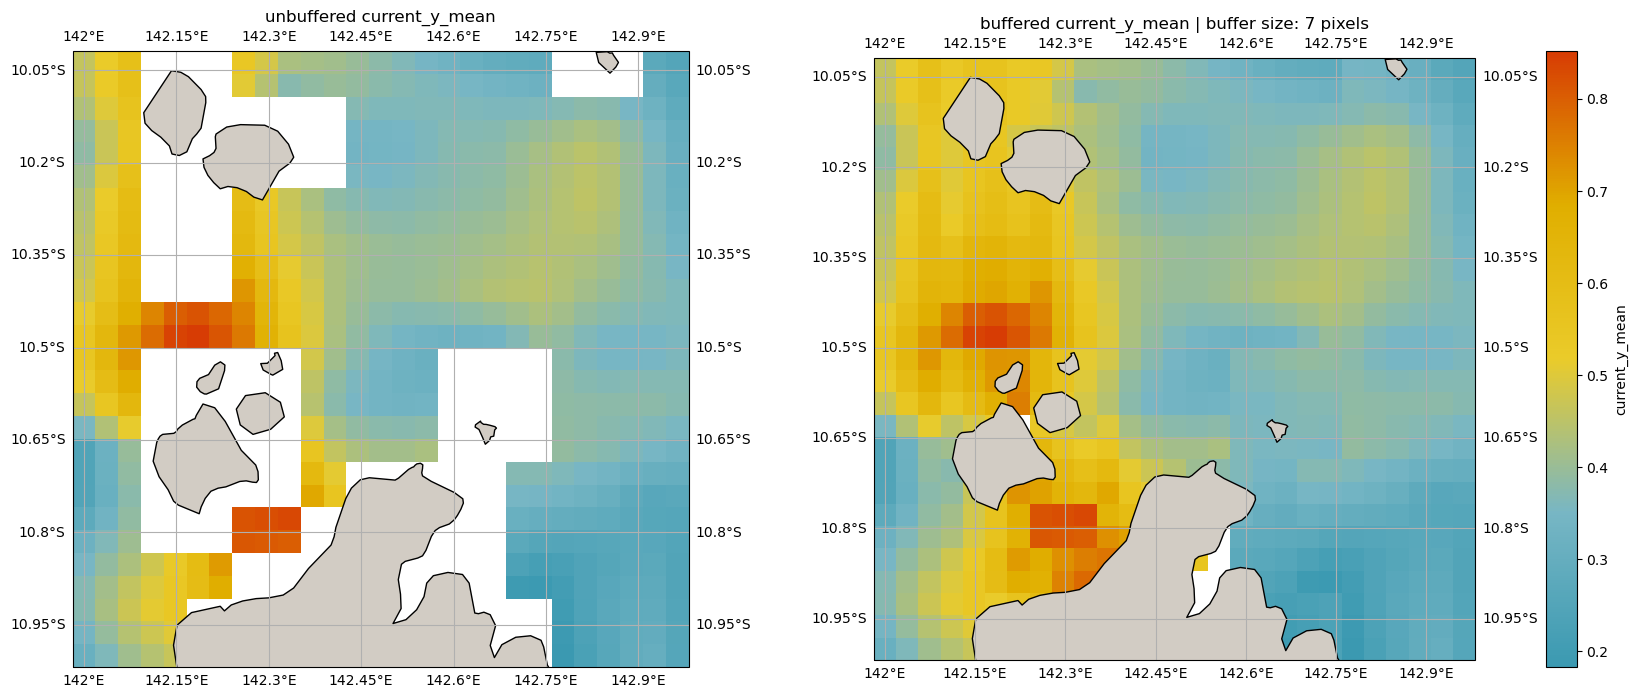

In [ ]:
# spatially buffer data
buffer_size = 7
variable = "current_y_mean"
couce_buffered = spatial_data.spatially_buffer_timeseries(couce_xa, buffer_size=buffer_size, b)

# visualise difference
fig, axes = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})

_ = spatial_plots.plot_spatial(
    couce_xa[variable].sel({"latitude": slice(-11,-10), "longitude": slice(142,143)}),
    fax=(fig,axes[0]), title=f"unbuffered {variable}", cbar=False)

_ = spatial_plots.plot_spatial(
    couce_buffered[variable].sel({"latitude": slice(-11,-10), "longitude": slice(142,143)}),
    fax=(fig,axes[1]), title=f"buffered {variable} | buffer size: {buffer_size} pixels")


## Process data for machine learning

In [ ]:
# choose whether to split by pixel or by region. See report Section 4 for more details.
split_type = "spatial"
# if splitting spatially, adjust these as necessary
train_test_lat_divide = -15
train_direction = "N"

# generate train/test sets
X_train, X_test, y_train, y_test, _, _ = baselines.spatial_split_train_test(
    xa_dss=[couce_buffered],
    gt_label="gt",
    split_type=split_type,
    test_fraction=0.25,
    train_test_lat_divide=train_test_lat_divide,
    train_direction=train_direction)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7906, 20)
y_train shape: (7906,)
X_test shape: (2001, 20)
y_test shape: (2001,)


## Run machine learning models

In the following section, two example ML models may be trained from scratch or loaded from files containing models for which  hyperparameter-tuning took place over the complete dataset. Tuning was executed first via random search, and then a grid search centred around the best resulting parameters.

### Fresh models

In [ ]:
# initialise new models
rf_reg = RandomForestRegressor(random_state=42)
brt = GradientBoostingRegressor(random_state=42)

In [ ]:
# naively train models
rf_reg.fit(X_train, y_train);
brt.fit(X_train, y_train);

In [ ]:
# test models
models_output_dict = baselines.n_random_runs_preds_across_models(
    model_types=["rf_reg", "brt"],
    models=[rf_reg, brt], 
    xa_dss = couce_buffered, 
    runs_n=5,
    split_type=split_type,
    train_test_lat_divide=train_test_lat_divide,
    train_direction=train_direction)


Inference on 5 train-test splits: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


Iterating over models: 100%|██████████| 2/2 [00:00<00:00, 65.72it/s]


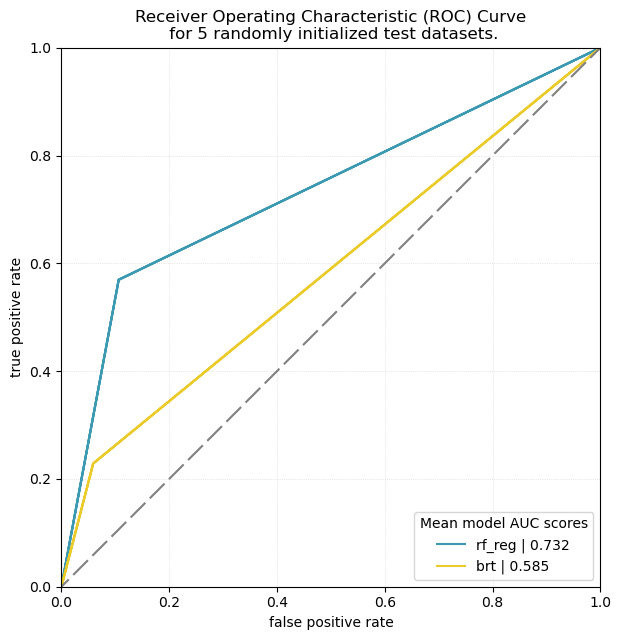

In [ ]:
# ROC curve, threshold as described in report
baselines.models_rocs_n_runs(models_output_dict, binarize_threshold=0.25)

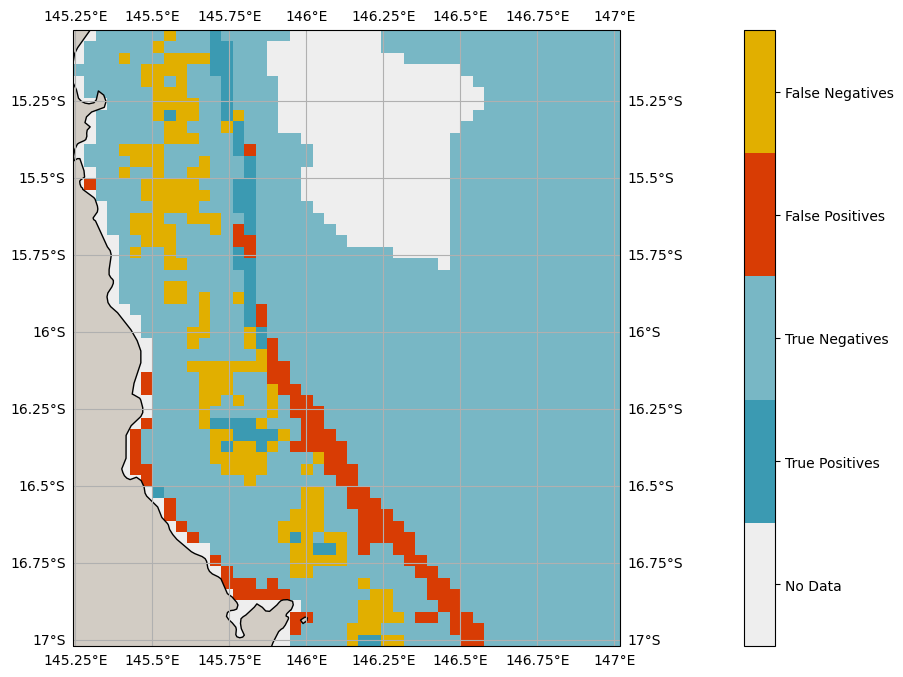

In [ ]:
# visualise residuals
model_type = "brt"

labels = models_output_dict[model_type][0][0]
predictions = models_output_dict[model_type][0][1]

_ = model_results.model_output_to_spatial_confusion(labels, predictions, threshold=0.25)

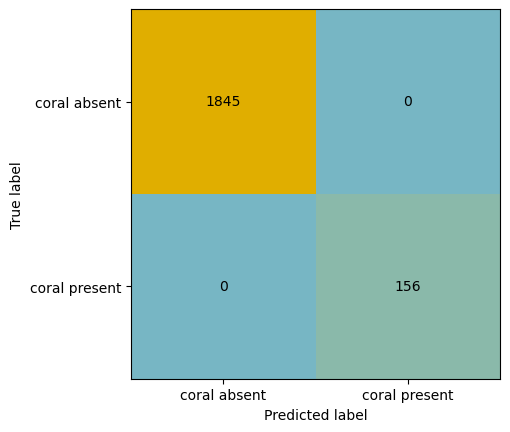

In [ ]:
model_results.plot_confusion_matrix(labels, predictions, label_threshold=0.25)

### Pre-trained models

In [69]:
if split_type == "spatial":
    dir = directories.get_coralshift_dir() / "best_models/spatial_models"
    print("Boosted Regression Trees optimal hyperparameters:")
    brt_trained = baselines.load_model(dir / "brt_0-0370d_tuned.pickle")
    print("Random Forest Regressor optimal hyperparameters:")
    rf_reg_trained = baselines.load_model(dir / "rf_reg_0-0370d_tuned.pickle")
elif split_type == "pixel":
    dir = directories.get_coralshift_dir() / "best_models/pixel_models"
    print("Boosted Regression Trees optimal hyperparameters:")
    brt_trained = baselines.load_model(dir / "brt_0-0370d_tuned.pickle")
    print("Random Forest Regressor optimal hyperparameters:")
    rf_reg_trained = baselines.load_model(dir / "rf_reg_0-0370d_tuned.pickle")
else:
    print(f"split_type: {split_type} not recognised.")

Boosted Regression Trees optimal hyperparameters:
{'subsample': 0.30000000000000004, 'n_estimators': 733, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 8, 'loss': 'huber', 'learning_rate': 0.0021544346900318843, 'criterion': 'friedman_mse'}
Random Forest Regressor optimal hyperparameters:
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}


In [ ]:
# test_file = xa.open_dataset(
#     directories.get_datasets_dir() / "comparison_resolutions/Great_Barrier_Reef_A/0-0370d_arrays/all_0-0370d_comparative.nc")
# test_file